# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Root hydraulics

How to 

1. Root water uptake from a static soil 

2. Root hydraulic conductance (Krs)  

3. Standard uptake fraction (SUF)


In [5]:
from IPython.display import SVG, display # to show svg files in the notebook

import os
sourcedir = os.getcwd()+"/../../.."
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import numpy as np
import matplotlib.pyplot as plt
import plantbox as pb 
import visualisation.vtk_plot as vp # for quick vizualisations

### Root water uptake from a static soil 

In [6]:
from functional.PlantHydraulicParameters import PlantHydraulicParameters  
from functional.PlantHydraulicModel import HydraulicModel_Doussan
# from functional.PlantHydraulicModel import HydraulicModel_Meunier  

Water flow in the hydraulic tree is computed according to the xylem water potential gradients between nodes, driven by the boundary condition at the root collar. At the root collar, either the water potential or the water flux can be prescribed (Dirichlet or Neumann boundary conditions). Root water uptake is computed as the sum of the radial fluxes into each root segment, according the the water potential differences between xylem and soil. 
In the example below, we set a constant and uniform total soil water potential, and constant root hydraulic properties. 

Seed::initialize: RootSystem 
MappedPlant::initializeLB 
Root collar potential -1000 [cm], transpiration -18.3495 [cm3/day]
Root collar potential -681.482 [cm], transpiration -10 [cm3/day]
Seed::initialize: RootSystem 
added radial flux


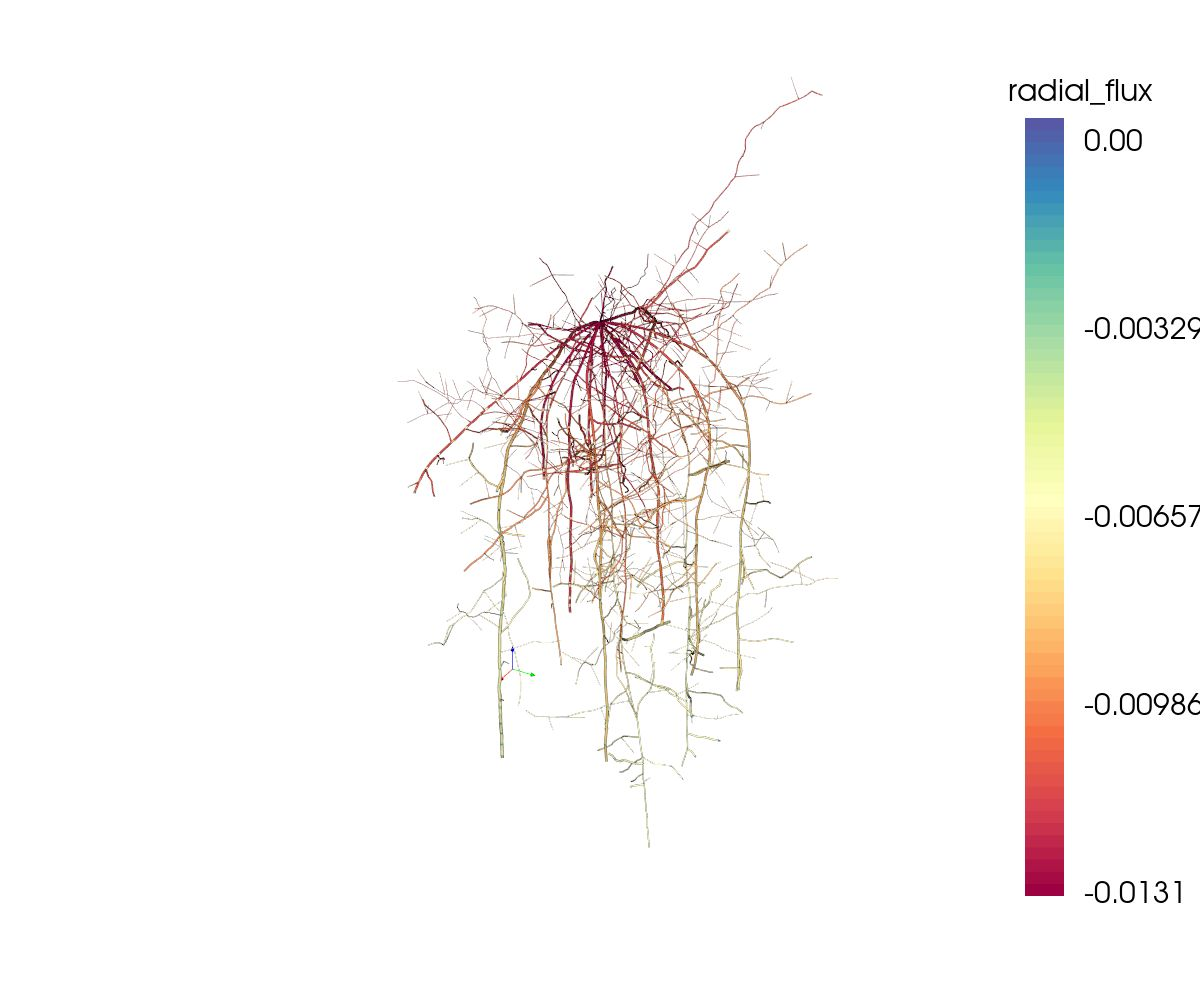

writing VTP: restuls/example4_1_roothydraulics.vtp


In [36]:
""" Parameters """  # 
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
h0 = -1000  # dirichlet bc at top [cm] 
t_pot = -10  # potential plant transpiration [cm3/day] 

""" root system """  
plant = pb.MappedPlant()  
path = "../../../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize()
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params)  
# hm = HydraulicModel_Meunier(plant, params)

""" Numerical solution """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,)))  
hx = hm.solve_dirichlet(initial_age, h0, hsr, cells = False) 
print("Root collar potential {:g} [cm], transpiration {:g} [cm3/day]".format(hx[0], hm.get_transpiration(initial_age, hx, hsr)))
hx = hm.solve_neumann(initial_age, t_pot, hsr, cells = False)  
print("Root collar potential {:g} [cm], transpiration {:g} [cm3/day]".format(hx[0], hm.get_transpiration(initial_age, hx, hsr)))  # |\label{l41:numerical_end}|

""" Additional vtk plot """
ana = pb.SegmentAnalyser(hm.ms.mappedSegments())  
ana.addData("hx", hx)  # xylem potentials [cm]
ana.addData("SUF", hm.get_suf(initial_age))  # standard uptake fraction [1]
ana.addAge(initial_age)  # age [day] 
ana.addHydraulicConductivities(params, initial_age)  # kr [1/day], kx [cm3/day] 
ana.addFluxes(hm, hx, hsr, initial_age)  # "axial_flux" [cm3/day], "radial_flux" [ (cm3/cm2) / day] 
vp.plot_plant(ana, "radial_flux", interactiveImage = False)  

""" output for paraview """
ana.write("restuls/example4_1_roothydraulics.vtp",  
          types = ["radius", "subType", "age", "hx", "SUF", "kr", "kx", "axial_flux", "radial_flux"])


Potential transpiration

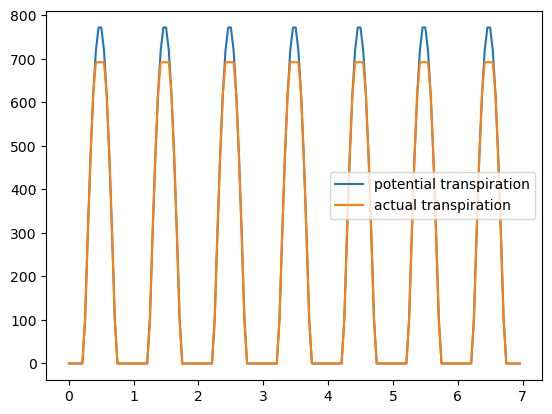

In [37]:
""" Parameters """  
sim_time = 7
dt = 3600./(24.*3600)
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
t_pot = -250  # potential plant transpiration per day [cm3/day] 

def sinusoidal2(t, dt):
    """ sinusoidal function from 6:00 - 18:00, 0 otherwise (used for transpiration, integral over one day is 1)"""
    return np.maximum(0., np.pi * (np.cos(2 * np.pi * (t - 0.5)) + np.cos(2 * np.pi * ((t + dt) - 0.5))) / 2)

""" root system """  
plant = pb.MappedPlant()  
path = "../../../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize(False)
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params)  

""" Simulation loop """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,)))  # static uniform total potential

N = int(sim_time/dt)
t_act_ = []
for i in range(0, N):
    t = i*dt # current simulation time 
    rx = hm.solve(initial_age, t_pot*sinusoidal2(t,dt), hsr, cells = False)  
    t_act = hm.get_transpiration(sim_time, rx, hsr, cells = False)
    t_act_.append(t_act)

t = np.linspace(0, (N-1)*dt, N)
plt.plot(t, -t_pot*sinusoidal2(t,dt), label = "potential transpiration")
plt.plot(t, -np.array(t_act_), label = "actual transpiration")
plt.legend()
plt.show()

Age dependent conductivities

0.357
0.00411

SubType 0 for negative age: kx = 0.0001, kr = 0.0001
SubType 0 for old root age: kx = 0.0001, kr = 0.0001
SubType 1 for negative age: kx = 0.0674, kr = 0.00114
SubType 1 for old root age: kx = 0.357, kr = 0.000517
SubType 2 for negative age: kx = 0.000407, kr = 0.00411
SubType 2 for old root age: kx = 0.0136, kr = 0.00158
SubType 3 for negative age: kx = 0.000407, kr = 0.00411
SubType 3 for old root age: kx = 0.0136, kr = 0.00158
SubType 4 for negative age: kx = 0.0674, kr = 0.00114
SubType 4 for old root age: kx = 0.357, kr = 0.000517



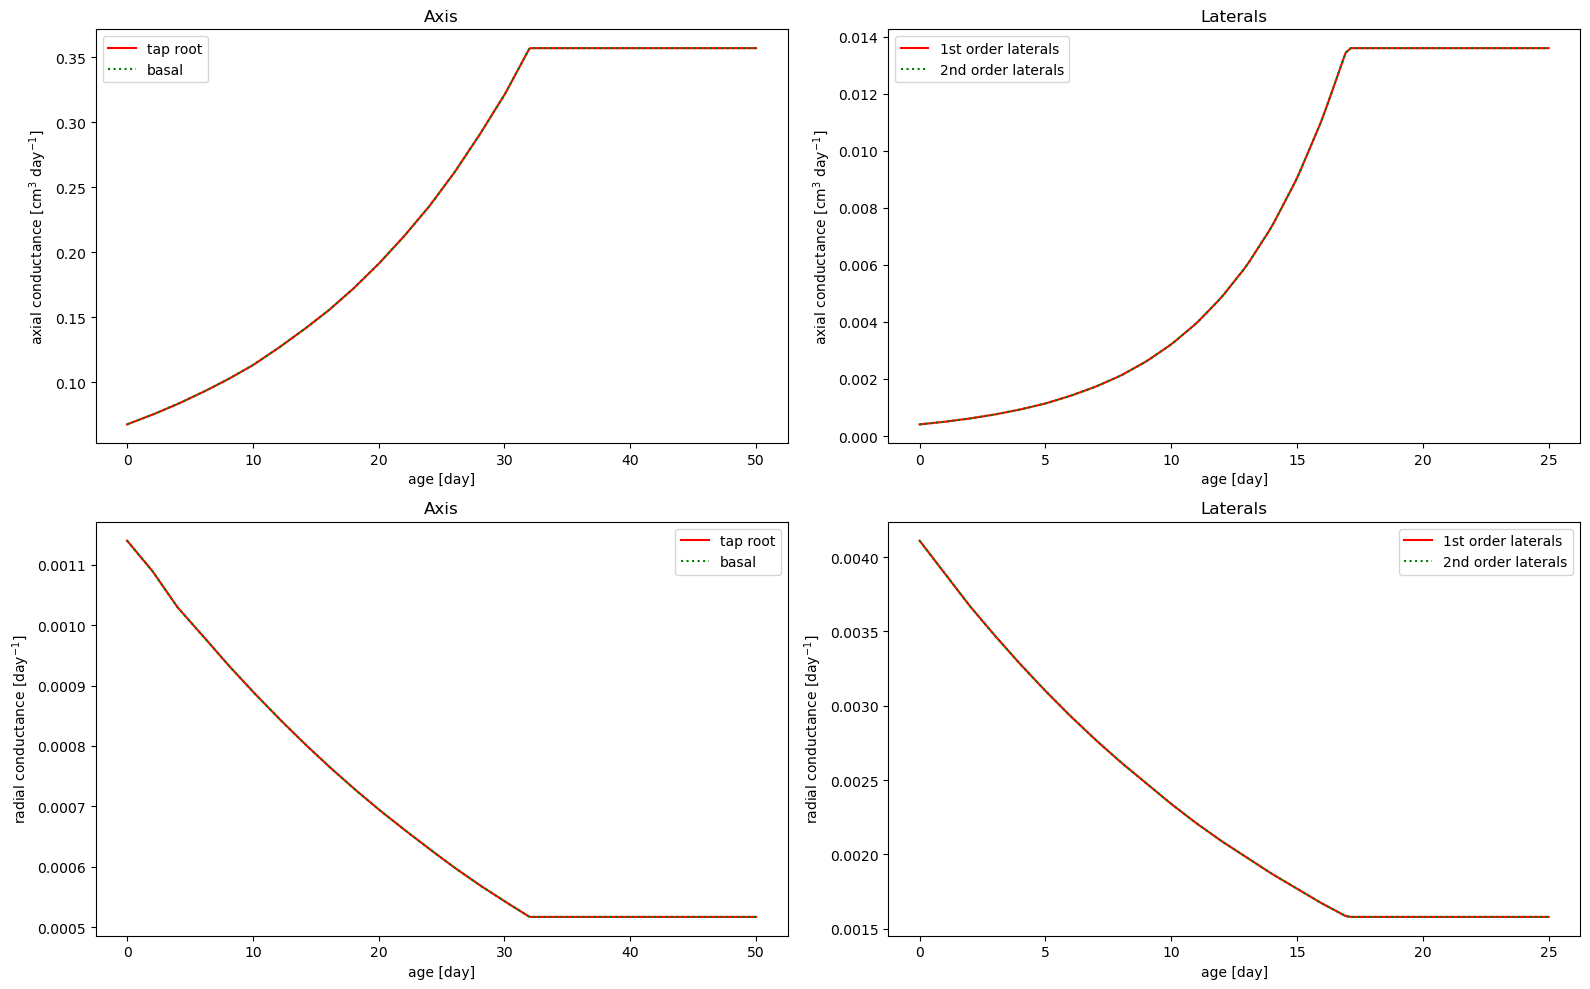

In [11]:
param = PlantHydraulicParameters()
kr0 = np.array([[0, 1.14e-03], [2, 1.09e-03], [4, 1.03e-03], [6, 9.83e-04], [8, 9.35e-04], [10, 8.90e-04], [12, 8.47e-04], [14, 8.06e-04], [16, 7.67e-04], [18, 7.30e-04], [20, 6.95e-04], [22, 6.62e-04], [24, 6.30e-04], [26, 5.99e-04], [28, 5.70e-04], [30, 5.43e-04], [32, 5.17e-04]])
kr1 = np.array([[0, 4.11e-03], [1, 3.89e-03], [2, 3.67e-03], [3, 3.47e-03], [4, 3.28e-03], [5, 3.10e-03], [6, 2.93e-03], [7, 2.77e-03], [8, 2.62e-03], [9, 2.48e-03], [10, 2.34e-03], [11, 2.21e-03], [12, 2.09e-03], [13, 1.98e-03], [14, 1.87e-03], [15, 1.77e-03], [16, 1.67e-03], [17, 1.58e-03]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1,4])
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 6.74e-02], [2, 7.48e-02], [4, 8.30e-02], [6, 9.21e-02], [8, 1.02e-01], [10, 1.13e-01], [12, 1.26e-01], [14, 1.40e-01], [16, 1.55e-01], [18, 1.72e-01], [20, 1.91e-01], [22, 2.12e-01], [24, 2.35e-01], [26, 2.61e-01], [28, 2.90e-01], [30, 3.21e-01], [32, 3.57e-01]])
kx1 = np.array([[0, 4.07e-04], [1, 5.00e-04], [2, 6.15e-04], [3, 7.56e-04], [4, 9.30e-04], [5, 1.14e-03], [6, 1.41e-03], [7, 1.73e-03], [8, 2.12e-03], [9, 2.61e-03], [10, 3.21e-03], [11, 3.95e-03], [12, 4.86e-03], [13, 5.97e-03], [14, 7.34e-03], [15, 9.03e-03], [16, 1.11e-02], [17, 1.36e-02]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1,4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3])

_ = param.plot_conductivities(axes_ind = [1,4], lateral_ind = [2, 3])

### Root hydraulic conductance (Krs) 

Root system conductance (Krs) for different root architectures over time: 


Simulating: Heliantus_Pagès_2013

Simulating: Glycine_max_Moraes2020_opt2

Simulating: Brassica_oleracea_Vansteenkiste_2014

Simulating: Zea_mays_1_Leitner_2010


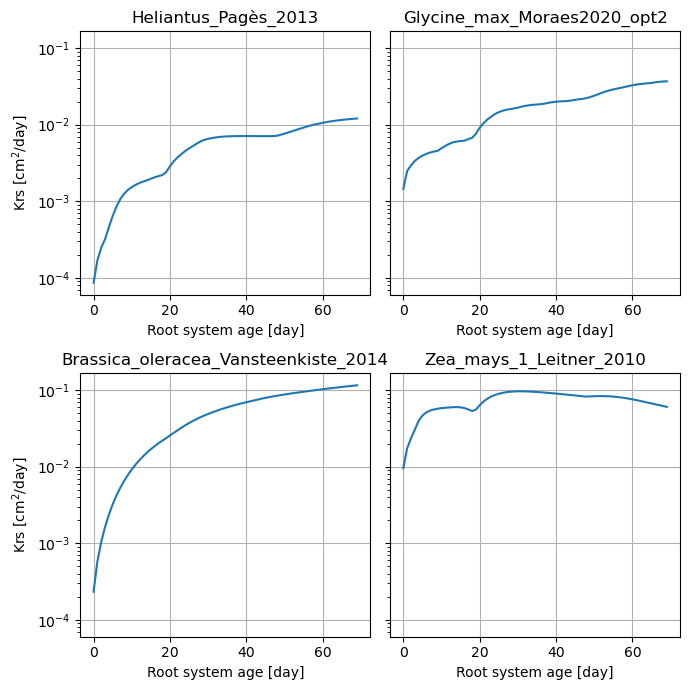


Summary:
Heliantus_Pagès_2013 | Total root length: 13467.76 cm | Surface area:   910.66 cm2
Glycine_max_Moraes2020_opt2 | Total root length:  8587.32 cm | Surface area:  1670.37 cm2
Brassica_oleracea_Vansteenkiste_2014 | Total root length: 26273.10 cm | Surface area:  2297.34 cm2
Zea_mays_1_Leitner_2010 | Total root length: 10730.86 cm | Surface area:  2001.21 cm2


In [38]:
simtime = 70  
dt = 1

architectures = [  
    "Heliantus_Pagès_2013",
    "Glycine_max_Moraes2020_opt2",
    "Brassica_oleracea_Vansteenkiste_2014",
    "Zea_mays_1_Leitner_2010"
]

path = "../../../modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]])
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 

""" Simulation loop""" 
krs_all, lengths, surfaces  = [], [], []

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize(False)

    hm = HydraulicModel_Meunier(plant, param) 
    krs_values = []
    arch_lengths = []
    arch_surfaces = []
    N = int(sim_time/dt)
    for t in range(0, N):
        plant.simulate(dt)    
        krs, _ = hm.get_krs(t)
        krs_values.append(krs)  
        total_length = np.sum(np.array(plant.getParameter("length")))
        total_surface = np.sum(np.array(plant.getParameter("surface")))
        arch_lengths.append(total_length)
        arch_surfaces.append(total_surface)        

    krs_all.append(krs_values)
    lengths.append(arch_lengths[-1])  # final length
    surfaces.append(arch_surfaces[-1])  # final surface 

""" Plot """  
fig, axes = plt.subplots(2, 2, figsize = (7,7), sharey = True)
for i, ax in enumerate(axes.flat):
    ax.plot(range(0, simtime), krs_all[i])
    ax.set_title(architectures[i])
    ax.set_xlabel("Root system age [day]")
    ax.set_yscale("log")
    if i%2 == 0:
        ax.set_ylabel("Krs [cm$^2$/day]")
    ax.grid(True)
plt.tight_layout()
plt.show()  

print("\nSummary:")
for i, name in enumerate(architectures):
    print(f"{name:20s} | Total root length: {lengths[i]:8.2f} cm | Surface area: {surfaces[i]:8.2f} cm2")

### Standard uptake fraction (SUF)


Simulating: Heliantus_Pagès_2013
MappedPlant::initializeLB 

Simulating: Glycine_max_Moraes2020_opt2
Seed::initialize: RootSystem 
MappedPlant::initializeLB 

Simulating: Brassica_oleracea_Vansteenkiste_2014
Seed::initialize: RootSystem 
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead

Simulating: Zea_mays_1_Leitner_2010
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


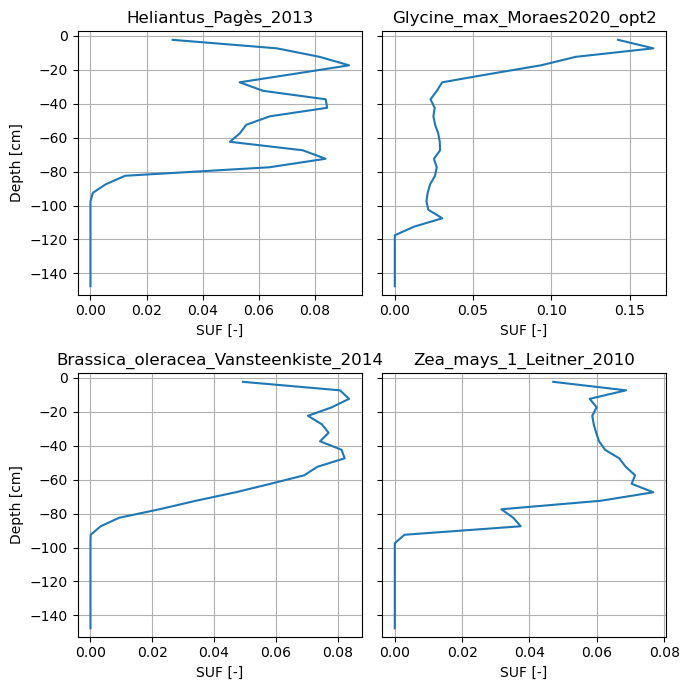

In [39]:
""" Simulation loop""" 
suf_profiles = [] # To store SUF depth profiles for all architectures at final simtime

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize()    
    hm = HydraulicModel_Meunier(plant, param)  # param from example before
    plant.simulate(simtime)

    suf = hm.get_suf(simtime)  
    ana = pb.SegmentAnalyser(plant)
    ana.addData("SUF", suf)  # suf at each segment in the 3d space

    bin_size = 5  # soil layer thickness is defined, for plotting purposes
    z_max = 0
    z_min = -150
    n_bins = int((z_max - z_min) / bin_size)
    suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True)  

    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins)  
    suf_array = np.array(suf_dist)
    depth_array = np.array(depths)
    
    suf_profiles.append((suf_array, depth_array)) # for plotting

""" Plotting """
fig_suf, axes_suf = plt.subplots(2, 2, figsize = (7,7), sharey = True)  

for i, ax in enumerate(axes_suf.flat):
    suf, depth = suf_profiles[i]
    ax.plot(suf, depth)
    ax.set_xlabel("SUF [-]")
    if i % 2 == 0:
        ax.set_ylabel("Depth [cm]")
    ax.grid(True)
    ax.set_title(architectures[i])
    if len(depth) > 0:
        ax.set_ylim(depth.min() - 5, depth.max() + 5)  # optional padding

plt.tight_layout()
plt.show()  